In [2]:
import matplotlib.font_manager as fm

names = sorted(set(f.name for f in fm.fontManager.ttflist))
for n in names:
    print(n)


Agency FB
Algerian
AniMe Matrix - MB_EN
Arial
Arial Rounded MT Bold
Bahnschrift
Baskerville Old Face
Bauhaus 93
Bell MT
Berlin Sans FB
Berlin Sans FB Demi
Bernard MT Condensed
Blackadder ITC
Bodoni MT
Book Antiqua
Bookman Old Style
Bookshelf Symbol 7
Bradley Hand ITC
Britannic Bold
Broadway
Brush Script MT
Calibri
Californian FB
Calisto MT
Cambria
Candara
Castellar
Centaur
Century
Century Gothic
Century Schoolbook
Chiller
Colonna MT
Comic Sans MS
Consolas
Constantia
Cooper Black
Copperplate Gothic Bold
Copperplate Gothic Light
Corbel
Courier New
Curlz MT
DFKai-SB
DejaVu Sans
DejaVu Sans Display
DejaVu Sans Mono
DejaVu Serif
DejaVu Serif Display
Dubai
Ebrima
Edwardian Script ITC
Elephant
Engravers MT
Eras Bold ITC
Eras Demi ITC
Eras Light ITC
Eras Medium ITC
Felix Titling
Footlight MT Light
Forte
Franklin Gothic Book
Franklin Gothic Demi
Franklin Gothic Demi Cond
Franklin Gothic Heavy
Franklin Gothic Medium
Franklin Gothic Medium Cond
Freestyle Script
French Script MT
Gabriola
Gadugi
Ga

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

In [23]:
files_dir = 'files/'
sales = pd.read_csv(files_dir + 'sales.csv')
sales_info = pd.read_csv(files_dir + 'sales_info.csv')
client = pd.read_csv(files_dir + 'client.csv')

In [ ]:
# ---------- 共用：彙總與畫圓餅 ----------

def _aggregate_total(sales: pd.DataFrame, sales_info: pd.DataFrame, by_col: str, merge_key: str = "product_id") -> pd.DataFrame:
    """
    依指定欄位彙總 amount*price。預設以 product_id 合併。
    """
    df = sales.merge(sales_info, on=merge_key)
    df["total"] = df["amount"] * df["price"]
    agg = df.groupby(by_col, as_index=False)["total"].sum()
    # 排序方便取前 N
    return agg.sort_values("total", ascending=False, ignore_index=True)

def _pie(df: pd.DataFrame, label_col: str, value_col: str = "total", top_n: int = 10, min_pct: float = 0.01, title: str = ""):
    """
    畫圓餅圖，保留前 top_n，其餘合併為 Others；或占比 < min_pct 也併入 Others。
    不設定顏色，維持預設配色。
    """
    total_sum = df[value_col].sum()
    if total_sum == 0:
        raise ValueError("總額為 0，無法繪製圓餅圖")

    # 先取前 N
    df_top = df.head(top_n).copy()

    # 將占比太小的項目也歸入 Others
    df_top["pct"] = df_top[value_col] / total_sum
    small_mask = df_top["pct"] < min_pct
    others_from_top = df_top.loc[small_mask, value_col].sum()

    df_top = df_top.loc[~small_mask, [label_col, value_col]]

    # 其餘剩下的項目
    remainder = df.iloc[top_n:][value_col].sum()
    others = others_from_top + remainder

    if others > 0:
        df_top.loc[len(df_top)] = ["Others", others]

    # 畫圖
    plt.figure(figsize=(6, 6))
    plt.pie(
        df_top[value_col],
        labels=df_top[label_col],
        autopct="%.1f%%",
        startangle=90
    )
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()

# ---------- 1. by sales_id（圓餅） ----------
def pie_chart_by_sales_id(sales: pd.DataFrame, sales_info: pd.DataFrame, top_n: int = 10, min_pct: float = 0.01):
    df = _aggregate_total(sales, sales_info, by_col="sale_id", merge_key="product_code")
    _pie(df, label_col="sale_id", value_col="total", top_n=top_n, min_pct=min_pct, title="Sales Share by sale_id")

# ---------- 2. by product_name（圓餅） ----------
def pie_chart_by_product_name(sales: pd.DataFrame, sales_info: pd.DataFrame, top_n: int = 10, min_pct: float = 0.01):
    df = _aggregate_total(sales, sales_info, by_col="product_name", merge_key="product_code")
    _pie(df, label_col="product_name", value_col="total", top_n=top_n, min_pct=min_pct, title="Sales Share by product_name")

# ---------- 3. by client_name（圓餅） ----------
def pie_chart_by_client_name(sales: pd.DataFrame, client: pd.DataFrame, top_n: int = 10, min_pct: float = 0.01):
    df = _aggregate_total(sales, client, by_col="client_name", merge_key="product_code")
    _pie(df, label_col="client_name", value_col="total", top_n=top_n, min_pct=min_pct, title="Sales Share by client_name")

# ---------- 4. 折線圖：x = sale_date, y = sum(amount*price) ----------
def line_chart_by_sale_date(sales: pd.DataFrame, sales_info: pd.DataFrame, merge_key: str = "product_code", max_xticks: int = 12):
    """
    以日期為 X 軸，總銷售為 Y。自動稀疏 X 軸標籤，避免每個日期都顯示。
    """
    df = sales.merge(sales_info, on=merge_key)
    df["total"] = df["amount"] * df["price"]

    # 日期標準化
    df["sale_date"] = pd.to_datetime(df["sale_date"])
    daily = df.groupby("sale_date", as_index=False)["total"].sum().sort_values("sale_date")

    # 繪圖
    plt.figure(figsize=(20, 5))
    plt.plot(daily["sale_date"].dt.strftime("%Y-%m-%d"), daily["total"], marker="o", linewidth=2)

    # 精簡 X 軸標籤：最多 max_xticks 個
    n = len(daily)
    if n > 0:
        step = max(1, n // max_xticks)
        xticks = daily["sale_date"].dt.strftime("%Y-%m-%d")[::step]
        plt.xticks(xticks, rotation=45, ha="right")

    plt.xlabel("Sale Date (YYYY-MM-DD)")
    plt.ylabel("Total Sales")
    plt.title("Daily Sales (Line Chart)")
    plt.tight_layout()
    plt.show()

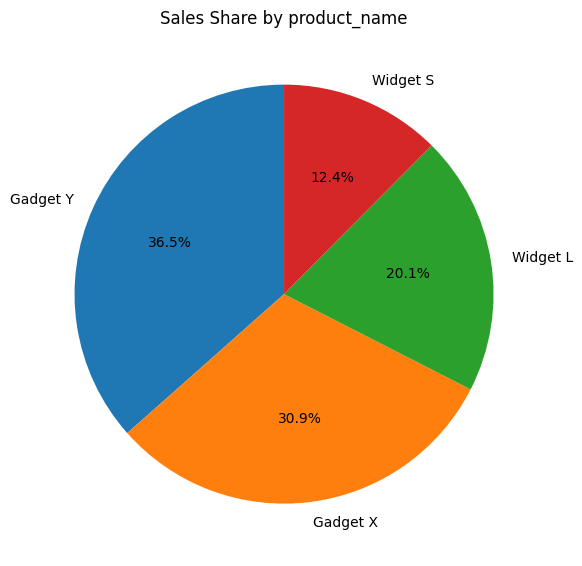

In [47]:
pie_chart_by_product_name(sales=sales, sales_info=sales_info, top_n=10, min_pct=0.1)

    sale_id      total
0         4  636350100
1        22  625302900
2        19  623883200
3        20  611402400
4        11  611227000
5        12  604007000
6        18  603127000
7        13  601135700
8        14  597921500
9         6  593622900
10        8  591296700
11        7  576886200
12       17  572557600
13        5  561612300
14        9  552260300
15       10  523909300
16       21  521111900
17        2  518140200
18       16  510599200
19       15  510441800
20        3  507451200
21        1  497475800
22       24  494720800
23       23  472759600


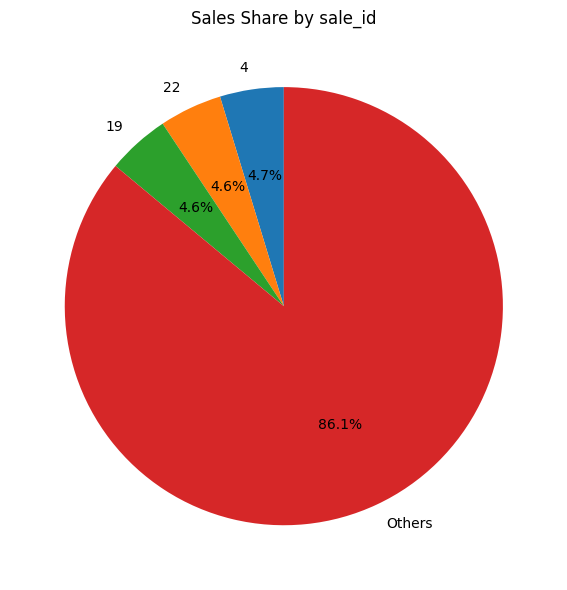

In [55]:
pie_chart_by_sales_id(sales=sales, sales_info=sales_info, top_n=3, min_pct=0.001)

In [56]:
pie_chart_by_client_name(sales=sales, client=client)

TypeError: pie_chart_by_client_name() got an unexpected keyword argument 'client'

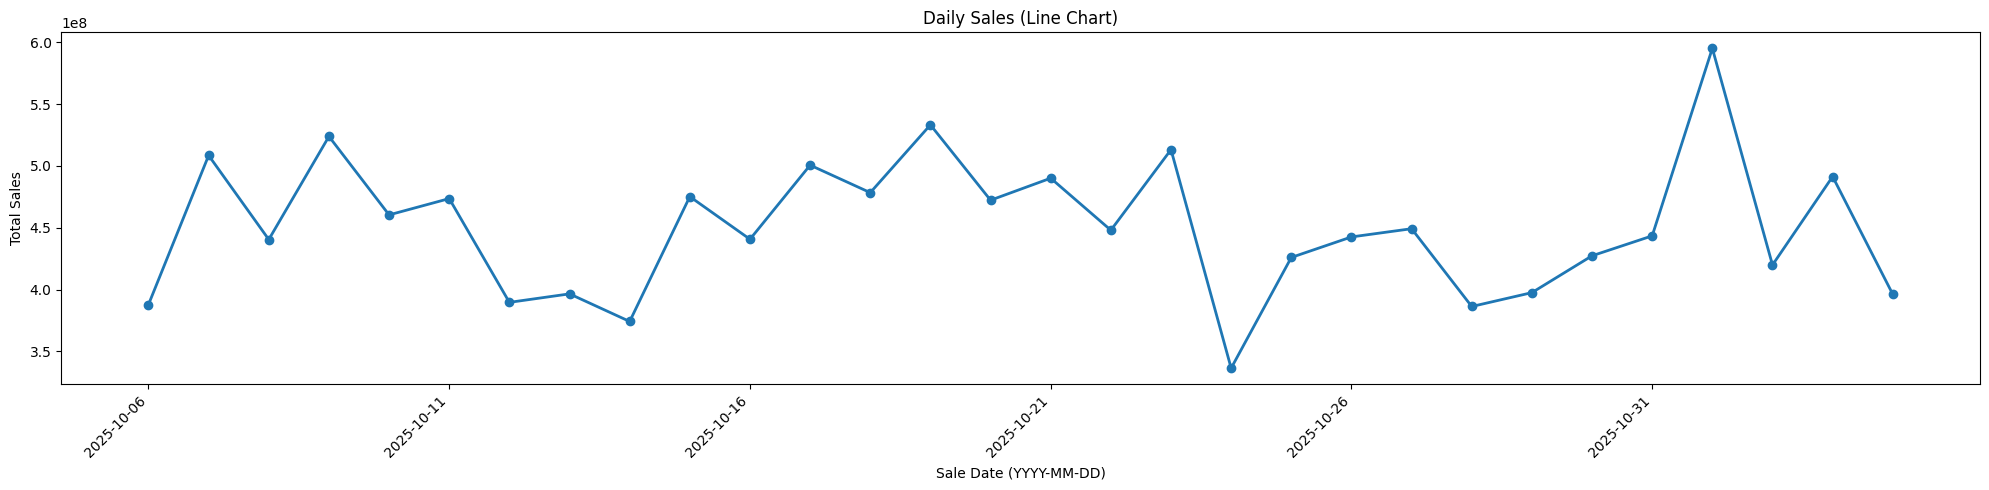

In [40]:
line_chart_by_sale_date(sales=sales, sales_info=sales_info)